## Install requirements:
```bash
# in terminal
pip install pandas numpy seaborn matplotlib
```

## Importing Requirment

In [40]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

## Importing Files as pandas DataFrame

In [41]:
# Read files into dataframes using appropriate methods
data_dir = Path('..') / 'data' / 'raw'  # Go up one level from 'data analysis' to reach root
behav = pd.read_csv(data_dir / 'QVI_purchase_behaviour.csv')
transac = pd.read_excel(data_dir / 'QVI_transaction_data.xlsx')

In [42]:
behav.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72637 entries, 0 to 72636
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   LYLTY_CARD_NBR    72637 non-null  int64 
 1   LIFESTAGE         72637 non-null  object
 2   PREMIUM_CUSTOMER  72637 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.7+ MB


In [43]:
# Remove any null, na, or NaN values from the behavior dataframe
behav = behav.dropna()

# Drop duplicate loyalty card numbers, keeping the first occurrence
behav = behav.drop_duplicates(subset='LYLTY_CARD_NBR', keep='first')

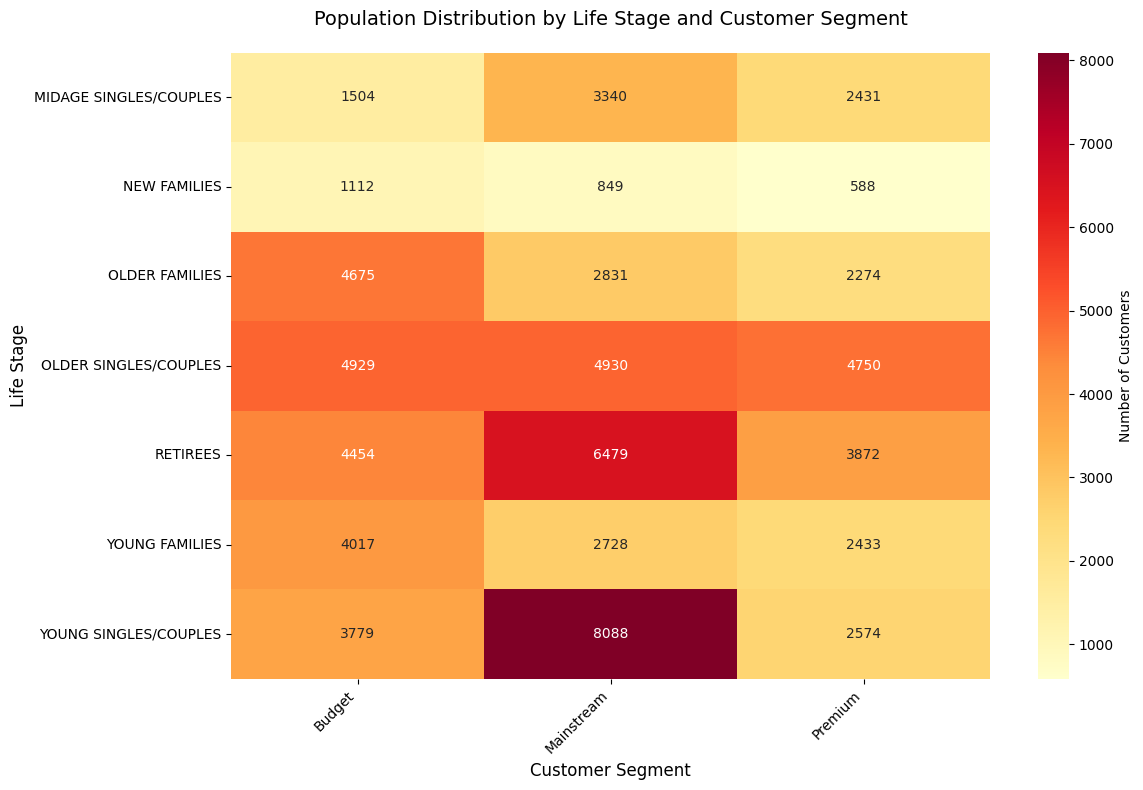

In [44]:
visuals_dir = Path('visuals')
visuals_dir.mkdir(exist_ok=True)

population_pivot = pd.crosstab(behav['LIFESTAGE'], behav['PREMIUM_CUSTOMER'])

fig, ax = plt.subplots(figsize=(12, 8))

sns.heatmap(population_pivot, 
            annot=True, 
            fmt='d', 
            cmap='YlOrRd', 
            cbar_kws={'label': 'Number of Customers'},
            ax=ax)

ax.set_title('Population Distribution by Life Stage and Customer Segment', pad=20, fontsize=14)
ax.set_xlabel('Customer Segment', fontsize=12)
ax.set_ylabel('Life Stage', fontsize=12)

plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

fig.tight_layout()

fig.savefig(visuals_dir / 'population_heatmap.png')

plt.show()


In [45]:
transac.head(10)

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
0,43390,1,1000,1,5,Natural Chip Compny SeaSalt175g,2,6.0
1,43599,1,1307,348,66,CCs Nacho Cheese 175g,3,6.3
2,43605,1,1343,383,61,Smiths Crinkle Cut Chips Chicken 170g,2,2.9
3,43329,2,2373,974,69,Smiths Chip Thinly S/Cream&Onion 175g,5,15.0
4,43330,2,2426,1038,108,Kettle Tortilla ChpsHny&Jlpno Chili 150g,3,13.8
5,43604,4,4074,2982,57,Old El Paso Salsa Dip Tomato Mild 300g,1,5.1
6,43601,4,4149,3333,16,Smiths Crinkle Chips Salt & Vinegar 330g,1,5.7
7,43601,4,4196,3539,24,Grain Waves Sweet Chilli 210g,1,3.6
8,43332,5,5026,4525,42,Doritos Corn Chip Mexican Jalapeno 150g,1,3.9
9,43330,7,7150,6900,52,Grain Waves Sour Cream&Chives 210G,2,7.2


## Date correction

In [46]:
# Convert Excel serial number date to datetime and keep only the date part (yyyy-mm-dd)
transac['DATE'] = pd.to_datetime(transac['DATE'], unit='D', origin='1899-12-30').dt.date

## Removing inconsistend Data

In [47]:
# Get unique words from product names (excluding numbers and special chars)
unique_words = (transac['PROD_NAME']
               .str.replace(r'[^a-zA-Z\s]', '', regex=True)  # Remove non-letters
               .str.split()  # Split into words
               .explode()  # Convert lists to rows
               .str.lower()  # Convert to lowercase
               .value_counts()  # Count frequency
               .reset_index())

unique_words.columns = ['Word', 'Frequency']

# Save unique words to CSV file in processed data folder
processed_data_dir = Path('..') / 'data' / 'processed'
unique_words.to_csv(processed_data_dir / 'unique_product_words.csv', index=False)

print("Most common words in product names:")
print(unique_words.head(20))

Most common words in product names:
        Word  Frequency
0          g     251231
1      chips      49770
2     kettle      41288
3     smiths      28860
4       salt      27976
5     cheese      27890
6   pringles      25102
7    doritos      24962
8    crinkle      23960
9       corn      22063
10  original      21560
11       cut      20754
12      chip      18645
13     salsa      18094
14   chicken      15407
15       sea      14145
16     thins      14075
17    chilli      13895
18      sour      13882
19    crisps      12607


After examining the product names, we found several non-chip products that need to be removed from our analysis:
- Salsa products (e.g. Old El Paso Salsa)
- Dips 
- Crackers
- Popcorn

These products are not relevant for our chips analysis and will be filtered out.


In [48]:
# Remove non-chip products
non_chip_words = ['salsa', 'dips', 'crackers', 'popcorn']
transac = transac[~transac['PROD_NAME'].str.lower().str.contains('|'.join(non_chip_words), na=False)]


## Brand names

In [49]:
# Extract first word as BRAND 
transac['BRAND'] = transac['PROD_NAME'].str.split().str[0]


In [50]:
# unique brand names
transac['BRAND'].value_counts()

BRAND
Kettle        41288
Smiths        27390
Pringles      25102
Doritos       22041
Thins         14075
RRD           11894
WW            10320
Cobs           9693
Tostitos       9471
Twisties       9454
Infuzions      7883
Tyrrells       6442
Grain          6272
Natural        6050
Cheezels       4603
CCs            4551
Red            4427
Dorito         3185
Infzns         3144
Smith          2963
Cheetos        2927
Snbts          1576
Burger         1564
Woolworths     1516
GrnWves        1468
Sunbites       1432
NCC            1419
French         1418
Name: count, dtype: int64

In [51]:
# Combine same brands with different names
brand_mapping = {
    'Red': 'RRD',  # Red Rock Deli
    'Dorito': 'Doritos',
    'Smith': 'Smiths',
    'Snbts': 'Sunbites',
    'Infzns': 'Infuzions',
    'GrnWves': 'Grain Waves',
    'Natural': 'Natural Chip Co',
    'French': 'French Fries'
}

# Replace brand names using the mapping
transac['BRAND'] = transac['BRAND'].replace(brand_mapping)

print("\nBrand names after combining similar brands:")
print(transac['BRAND'].value_counts())


Brand names after combining similar brands:
BRAND
Kettle             41288
Smiths             30353
Doritos            25226
Pringles           25102
RRD                16321
Thins              14075
Infuzions          11027
WW                 10320
Cobs                9693
Tostitos            9471
Twisties            9454
Tyrrells            6442
Grain               6272
Natural Chip Co     6050
Cheezels            4603
CCs                 4551
Sunbites            3008
Cheetos             2927
Burger              1564
Woolworths          1516
Grain Waves         1468
NCC                 1419
French Fries        1418
Name: count, dtype: int64


## Weight Category

In [52]:
# Extract weight in grams from PROD_NAME - match both 'g' and 'G'
transac['PACK_SIZE (in grams)'] = transac['PROD_NAME'].str.extract('(\d+)[gG]', expand=False)

In [53]:

# Get descriptive statistics
print("Descriptive statistics for PROD_QTY:")
print(transac['PROD_QTY'].describe())


Descriptive statistics for PROD_QTY:
count    243568.000000
mean          1.907948
std           0.662921
min           1.000000
25%           2.000000
50%           2.000000
75%           2.000000
max         200.000000
Name: PROD_QTY, dtype: float64


## Outliers

In [54]:
# Find transactions with unusually high quantities
Q1 = transac['PROD_QTY'].quantile(0.25)
Q3 = transac['PROD_QTY'].quantile(0.75)
IQR = Q3 - Q1
upper_bound = Q3 + 1.5 * IQR
# Get frequency of quantities above upper bound
print("\nFrequency of quantities above upper bound threshold:")
high_qty_freq = transac[transac['PROD_QTY'] > upper_bound]['PROD_QTY'].value_counts()
print(high_qty_freq)



Frequency of quantities above upper bound threshold:
PROD_QTY
5      406
3      405
4      366
200      2
Name: count, dtype: int64


In [55]:
# Get frequency of quantities below lower bound threshold
lower_bound = Q1 - 1.5 * IQR
print("\nFrequency of quantities below lower bound threshold:")
low_qty_freq = transac[transac['PROD_QTY'] < lower_bound]['PROD_QTY'].value_counts()
print(low_qty_freq)



Frequency of quantities below lower bound threshold:
PROD_QTY
1    25172
Name: count, dtype: int64


#### Removing Outliers
Based on the analysis above, we can see that there is one transaction with a quantity of 200 chips, which is an extreme outlier compared to typical purchase quantities. This appears to be a commercial purchase rather than a regular retail transaction, so we will remove it from our analysis to avoid skewing the results.

In [56]:
# Remove transactions with quantity of 200 (identified outlier)
transac = transac[transac['PROD_QTY'] != 200].reset_index(drop=True)

## Consistency in date

In [57]:
# Count number of unique dates
unique_dates = transac['DATE'].nunique()
print(f"\nNumber of unique dates: {unique_dates}")


Number of unique dates: 364


In [58]:
# Create a complete date range from Jul 1 2018 to Jun 30 2019
date_range = pd.date_range(start='2018-07-01', end='2019-06-30', freq='D')

# First convert DATE column to datetime if it's not already
transac['DATE'] = pd.to_datetime(transac['DATE'])

# Get unique dates from transactions
unique_transaction_dates = pd.to_datetime(transac['DATE'].unique())

# Convert both to sets for comparison
date_range_set = set(date_range)
transaction_dates_set = set(unique_transaction_dates)

# Find the missing date
missing_date = date_range_set - transaction_dates_set
print("\nMissing date:", list(missing_date)[0].strftime('%Y-%m-%d'))

#### Christmas holiday is the missing date


Missing date: 2018-12-25


In [59]:
# Check for missing values (both NaN and NA) in each column
transac.isna().sum() # isna() catches both NaN and NA


DATE                    0
STORE_NBR               0
LYLTY_CARD_NBR          0
TXN_ID                  0
PROD_NBR                0
PROD_NAME               0
PROD_QTY                0
TOT_SALES               0
BRAND                   0
PACK_SIZE (in grams)    0
dtype: int64

In [60]:
# Get rows with any missing values
missing_rows = transac[transac.isna().any(axis=1)]
print(missing_rows)

Empty DataFrame
Columns: [DATE, STORE_NBR, LYLTY_CARD_NBR, TXN_ID, PROD_NBR, PROD_NAME, PROD_QTY, TOT_SALES, BRAND, PACK_SIZE (in grams)]
Index: []


In [61]:
# Remove duplicates, keeping the first occurrence
transac = transac.drop_duplicates()


In [62]:
# Create a new column with just month and year from DATE
transac['MONTH_YEAR'] = pd.to_datetime(transac['DATE']).dt.to_period('M')
# Create a new column with just year from DATE
transac['YEAR'] = pd.to_datetime(transac['DATE']).dt.year
# Create a new column with just month name from DATE
transac['MONTH_NAME'] = pd.to_datetime(transac['DATE']).dt.month_name()


In [63]:
# Sort the transactions by date
transac = transac.sort_values('DATE').reset_index(drop=True)


In [64]:
transac.head(10)

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,BRAND,PACK_SIZE (in grams),MONTH_YEAR,YEAR,MONTH_NAME
0,2018-07-01,116,116179,120232,81,Pringles Original Crisps 134g,2,7.4,Pringles,134,2018-07,2018,July
1,2018-07-01,174,174315,175432,71,Twisties Cheese Burger 250g,2,8.6,Twisties,250,2018-07,2018,July
2,2018-07-01,89,89003,88123,6,RRD Lime & Pepper 165g,1,3.0,RRD,165,2018-07,2018,July
3,2018-07-01,30,30005,26519,53,RRD Sweet Chilli & Sour Cream 165g,2,6.0,RRD,165,2018-07,2018,July
4,2018-07-01,21,21037,17576,62,Pringles Mystery Flavour 134g,2,7.4,Pringles,134,2018-07,2018,July
5,2018-07-01,122,122015,124747,77,Doritos Corn Chips Nacho Cheese 170g,2,8.8,Doritos,170,2018-07,2018,July
6,2018-07-01,13,13133,11927,53,RRD Sweet Chilli & Sour Cream 165g,2,6.0,RRD,165,2018-07,2018,July
7,2018-07-01,210,210159,209607,63,Kettle 135g Swt Pot Sea Salt,2,8.4,Kettle,135,2018-07,2018,July
8,2018-07-01,20,20264,17245,50,Tostitos Lightly Salted 175g,1,4.4,Tostitos,175,2018-07,2018,July
9,2018-07-01,30,30043,26749,48,Red Rock Deli Sp Salt & Truffle 150G,2,5.4,RRD,150,2018-07,2018,July


In [65]:
transac.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243565 entries, 0 to 243564
Data columns (total 13 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   DATE                  243565 non-null  datetime64[ns]
 1   STORE_NBR             243565 non-null  int64         
 2   LYLTY_CARD_NBR        243565 non-null  int64         
 3   TXN_ID                243565 non-null  int64         
 4   PROD_NBR              243565 non-null  int64         
 5   PROD_NAME             243565 non-null  object        
 6   PROD_QTY              243565 non-null  int64         
 7   TOT_SALES             243565 non-null  float64       
 8   BRAND                 243565 non-null  object        
 9   PACK_SIZE (in grams)  243565 non-null  object        
 10  MONTH_YEAR            243565 non-null  period[M]     
 11  YEAR                  243565 non-null  int32         
 12  MONTH_NAME            243565 non-null  object        
dtyp

In [66]:
# Merge the two dataframes 'bahav' and 'transac' on the common key(s)
merged = pd.merge(transac, behav, on='LYLTY_CARD_NBR', how='left', validate='m:1')


In [67]:
merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243565 entries, 0 to 243564
Data columns (total 15 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   DATE                  243565 non-null  datetime64[ns]
 1   STORE_NBR             243565 non-null  int64         
 2   LYLTY_CARD_NBR        243565 non-null  int64         
 3   TXN_ID                243565 non-null  int64         
 4   PROD_NBR              243565 non-null  int64         
 5   PROD_NAME             243565 non-null  object        
 6   PROD_QTY              243565 non-null  int64         
 7   TOT_SALES             243565 non-null  float64       
 8   BRAND                 243565 non-null  object        
 9   PACK_SIZE (in grams)  243565 non-null  object        
 10  MONTH_YEAR            243565 non-null  period[M]     
 11  YEAR                  243565 non-null  int32         
 12  MONTH_NAME            243565 non-null  object        
 13 

In [68]:
merged.head(10)

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,BRAND,PACK_SIZE (in grams),MONTH_YEAR,YEAR,MONTH_NAME,LIFESTAGE,PREMIUM_CUSTOMER
0,2018-07-01,116,116179,120232,81,Pringles Original Crisps 134g,2,7.4,Pringles,134,2018-07,2018,July,YOUNG SINGLES/COUPLES,Mainstream
1,2018-07-01,174,174315,175432,71,Twisties Cheese Burger 250g,2,8.6,Twisties,250,2018-07,2018,July,OLDER SINGLES/COUPLES,Premium
2,2018-07-01,89,89003,88123,6,RRD Lime & Pepper 165g,1,3.0,RRD,165,2018-07,2018,July,OLDER SINGLES/COUPLES,Mainstream
3,2018-07-01,30,30005,26519,53,RRD Sweet Chilli & Sour Cream 165g,2,6.0,RRD,165,2018-07,2018,July,OLDER FAMILIES,Premium
4,2018-07-01,21,21037,17576,62,Pringles Mystery Flavour 134g,2,7.4,Pringles,134,2018-07,2018,July,RETIREES,Mainstream
5,2018-07-01,122,122015,124747,77,Doritos Corn Chips Nacho Cheese 170g,2,8.8,Doritos,170,2018-07,2018,July,YOUNG FAMILIES,Budget
6,2018-07-01,13,13133,11927,53,RRD Sweet Chilli & Sour Cream 165g,2,6.0,RRD,165,2018-07,2018,July,OLDER SINGLES/COUPLES,Mainstream
7,2018-07-01,210,210159,209607,63,Kettle 135g Swt Pot Sea Salt,2,8.4,Kettle,135,2018-07,2018,July,RETIREES,Budget
8,2018-07-01,20,20264,17245,50,Tostitos Lightly Salted 175g,1,4.4,Tostitos,175,2018-07,2018,July,RETIREES,Mainstream
9,2018-07-01,30,30043,26749,48,Red Rock Deli Sp Salt & Truffle 150G,2,5.4,RRD,150,2018-07,2018,July,OLDER FAMILIES,Premium


In [69]:
merged.to_csv(processed_data_dir / 'MergedData.csv', index=False)